In [ ]:
# 조원 정우철, 하가영, 최예준, 임세홍, 정은총

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import importlib
from importlib import util
import re
from konlpy.tag import Kkma
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

# 주제
    
    아파트 가격에 어떠한 요인이 영향을 미치는가?

  - 법정동코드에서 "서울특별시" 만 뽑고 읍면동에 대응하는 시군구명 뽑기.
  - 법정동코드에서 앞에 5자리(지역코드) 추출하기

# 1. 법정동 코드 가공

In [27]:
locCode = pd.read_excel('../data/법정동코드.xlsx')
locCode.head()

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,NaN,19880423,NaN
1,1111000000,서울특별시,종로구,NaN,NaN,19880423,NaN
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,NaN
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,NaN


In [28]:
#읍면동이 NaN인 데이터 추출 > 읍면동 제외
locCode.dropna(subset=['읍면동명'],inplace=True)
locCode.head()

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,NaN
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,NaN
5,1111010400,서울특별시,종로구,효자동,NaN,19880423,NaN
6,1111010500,서울특별시,종로구,창성동,NaN,19880423,NaN


In [29]:
# 시군구가 NaN이 아닌 데이터 추출 > 시도명 제외

locCode.dropna(subset=['시군구명'],inplace=True)
locCode.head()

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,NaN
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,NaN
5,1111010400,서울특별시,종로구,효자동,NaN,19880423,NaN
6,1111010500,서울특별시,종로구,창성동,NaN,19880423,NaN


In [30]:
# 법정동 코드 컬럼에서 5자리 추출합니다.
# 예) 서울특별시 종로구 > 11000
locCode['법정동코드']=locCode['법정동코드'].astype(str)
locCode['지역코드']=locCode['법정동코드'].apply(lambda x: x[:5])
locCode.head()


,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자,지역코드
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN,11110
3,1111010200,서울특별시,종로구,신교동,NaN,19880423,NaN,11110
4,1111010300,서울특별시,종로구,궁정동,NaN,19880423,NaN,11110
5,1111010400,서울특별시,종로구,효자동,NaN,19880423,NaN,11110
6,1111010500,서울특별시,종로구,창성동,NaN,19880423,NaN,11110


In [31]:
# 시도명이 서울특별시인 데이터만 추출 후 시도명, 시군구명, 지역코드 컬럼만 추출 

locCode=locCode[locCode['시도명']=='서울특별시']

loc=pd.DataFrame({'시도명':locCode['시도명'],'시군구명':locCode['시군구명'],'법정동명':locCode['읍면동명'], '지역코드':locCode['지역코드']})
loc


,시도명,시군구명,법정동명,지역코드
2,서울특별시,종로구,청운동,11110
3,서울특별시,종로구,신교동,11110
4,서울특별시,종로구,궁정동,11110
5,서울특별시,종로구,효자동,11110
6,서울특별시,종로구,창성동,11110
...,...,...,...,...
488,서울특별시,강동구,둔촌동,11740
489,서울특별시,강동구,암사동,11740
490,서울특별시,강동구,성내동,11740
491,서울특별시,강동구,천호동,11740


In [32]:
# 실거래가 데이터 불러오기
apt = pd.read_csv('../data/2020년 서울 아파트 실거래가.csv', encoding="cp949")
apt.head()

,법정동명,건물면적,층정보,건물주용도코드,건물주용도,거래금액,건축년도,아파트명
0,장위동,59.92,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티
1,길음동,84.77,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아
2,구로동,36.90,1.0,2001,아파트,105000000,1994.0,궁전아트빌라
3,산천동,59.55,2.0,2001,아파트,830000000,2001.0,리버힐삼성
4,이촌동,64.43,5.0,2001,아파트,735000000,1971.0,강변


In [9]:
# 데이터 프레임의 컬럼을 확인합니다.
apt.columns

Index(['법정동명', '건물면적', '층정보', '건물주용도코드', '건물주용도', '거래금액', '건축년도', '아파트명'], dtype='object')

In [10]:
# 데이터 프레임의 크기(차원)을 조회합니다
apt.shape

(176001, 8)

In [11]:
# 불러온 데이터에 NA값이 있는지 조회합니다.
apt.isnull().sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
175996    2
175997    2
175998    0
175999    2
176000    2
Length: 176001, dtype: int64

In [12]:
# 실거래가 데이터프레임 정보 조회
apt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176001 entries, 0 to 176000
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   법정동명     176001 non-null  object 
 1   건물면적     176001 non-null  float64
 2   층정보      163838 non-null  float64
 3   건물주용도코드  176001 non-null  int64  
 4   건물주용도    176001 non-null  object 
 5   거래금액     176001 non-null  int64  
 6   건축년도     175436 non-null  float64
 7   아파트명     163838 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 10.7+ MB


In [13]:
# 실거래가 데이터프레임 정보 조회 (거래금액 컬럼 변경 확인)
apt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176001 entries, 0 to 176000
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   법정동명     176001 non-null  object 
 1   건물면적     176001 non-null  float64
 2   층정보      163838 non-null  float64
 3   건물주용도코드  176001 non-null  int64  
 4   건물주용도    176001 non-null  object 
 5   거래금액     176001 non-null  int64  
 6   건축년도     175436 non-null  float64
 7   아파트명     163838 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 10.7+ MB


In [33]:
# 범주화된 전용면적의 고유값을 확인합니다.

apt['건물면적'] = apt['건물면적'].astype(int) // 3.3057
apt = apt.rename({'건물면적':'평수'},axis='columns')
apt

,법정동명,평수,층정보,건물주용도코드,건물주용도,거래금액,건축년도,아파트명
0,장위동,17,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티
1,길음동,25,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아
2,구로동,10,1.0,2001,아파트,105000000,1994.0,궁전아트빌라
3,산천동,17,2.0,2001,아파트,830000000,2001.0,리버힐삼성
4,이촌동,19,5.0,2001,아파트,735000000,1971.0,강변
...,...,...,...,...,...,...,...,...
175996,상암동,88,NaN,1001,단독주택,1450000000,1998.0,NaN
175997,연남동,44,NaN,1001,단독주택,2430000000,1973.0,NaN
175998,망원동,13,3.0,2002,연립주택,405000000,1983.0,(459-4)
175999,신수동,13,NaN,1001,단독주택,899900000,1967.0,NaN


In [34]:
apt=apt[apt['건물주용도']=='아파트']
apt

,법정동명,평수,층정보,건물주용도코드,건물주용도,거래금액,건축년도,아파트명
0,장위동,17,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티
1,길음동,25,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아
2,구로동,10,1.0,2001,아파트,105000000,1994.0,궁전아트빌라
3,산천동,17,2.0,2001,아파트,830000000,2001.0,리버힐삼성
4,이촌동,19,5.0,2001,아파트,735000000,1971.0,강변
...,...,...,...,...,...,...,...,...
175970,염리동,17,4.0,2001,아파트,626000000,1997.0,상록
175977,공덕동,34,4.0,2001,아파트,1330000000,2004.0,한화꿈에그린
175979,성산동,24,2.0,2001,아파트,560000000,2002.0,그레이스
175981,성산동,25,6.0,2001,아파트,600000000,2006.0,성산동자담이움아파트


In [35]:
apt.drop(columns=['건물주용도코드'],inplace=True)
apt

C:\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,법정동명,평수,층정보,건물주용도,거래금액,건축년도,아파트명
0,장위동,17,5.0,아파트,749000000,0.0,래미안 장위포레카운티
1,길음동,25,18.0,아파트,1200000000,0.0,롯데캐슬 클라시아
2,구로동,10,1.0,아파트,105000000,1994.0,궁전아트빌라
3,산천동,17,2.0,아파트,830000000,2001.0,리버힐삼성
4,이촌동,19,5.0,아파트,735000000,1971.0,강변
...,...,...,...,...,...,...,...
175970,염리동,17,4.0,아파트,626000000,1997.0,상록
175977,공덕동,34,4.0,아파트,1330000000,2004.0,한화꿈에그린
175979,성산동,24,2.0,아파트,560000000,2002.0,그레이스
175981,성산동,25,6.0,아파트,600000000,2006.0,성산동자담이움아파트


# 3. 데이터 프레임 결합

In [36]:
# 지역 코드를 기준으로 법정동 코드 데이터 프레임과 아파트 실거래가 데이터 프레임을 결합합니다.
df = pd.merge(loc,apt)
df

,시도명,시군구명,법정동명,지역코드,평수,층정보,건물주용도,거래금액,건축년도,아파트명
0,서울특별시,종로구,청운동,11110,25,3.0,아파트,895000000,2000.0,청운현대
1,서울특별시,종로구,청운동,11110,25,3.0,아파트,850000000,2000.0,청운현대
2,서울특별시,종로구,신교동,11110,40,5.0,아파트,1000000000,2002.0,신현(102동)
3,서울특별시,종로구,필운동,11110,32,7.0,아파트,940000000,2007.0,신동아블루아광화문의 꿈
4,서울특별시,종로구,필운동,11110,33,6.0,아파트,1000000000,2007.0,신동아블루아광화문의 꿈
...,...,...,...,...,...,...,...,...,...,...
90661,서울특별시,강동구,강일동,11740,25,4.0,아파트,820000000,2009.0,강일리버파크6단지
90662,서울특별시,강동구,강일동,11740,25,10.0,아파트,790000000,2009.0,강일리버파크3단지
90663,서울특별시,강동구,강일동,11740,17,12.0,아파트,830000000,2009.0,강일리버파크3단지
90664,서울특별시,강동구,강일동,11740,17,13.0,아파트,760000000,2009.0,강일리버파크7단지


In [18]:
df.drop_duplicates(ignore_index=True,inplace=True)
df

,시도명,시군구명,법정동명,지역코드,평수,층정보,건물주용도,거래금액,건축년도,아파트명
0,서울특별시,종로구,청운동,11110,25,3.0,아파트,895000000,2000.0,청운현대
1,서울특별시,종로구,청운동,11110,25,3.0,아파트,850000000,2000.0,청운현대
2,서울특별시,종로구,신교동,11110,40,5.0,아파트,1000000000,2002.0,신현(102동)
3,서울특별시,종로구,필운동,11110,32,7.0,아파트,940000000,2007.0,신동아블루아광화문의 꿈
4,서울특별시,종로구,필운동,11110,33,6.0,아파트,1000000000,2007.0,신동아블루아광화문의 꿈
...,...,...,...,...,...,...,...,...,...,...
88343,서울특별시,강동구,강일동,11740,25,4.0,아파트,820000000,2009.0,강일리버파크6단지
88344,서울특별시,강동구,강일동,11740,25,10.0,아파트,790000000,2009.0,강일리버파크3단지
88345,서울특별시,강동구,강일동,11740,17,12.0,아파트,830000000,2009.0,강일리버파크3단지
88346,서울특별시,강동구,강일동,11740,17,13.0,아파트,760000000,2009.0,강일리버파크7단지


# 데이터 분석 

      후보1 부동산 금액에 영향을 끼치는 요인들.  ☆ 당첨 ☆
      후보2 동일 지역의 아파트 평당 금액 차이의 원인 분석
      후보3 건축년도에 따른 금액차이.
      후보4 ex:서초구가 집값이 가장 비싼 이유는 왜일까?

## 부동산 거래가의 영향을 주는 요인들 
   
    요인1 - 사업체 수 

    요인2 - 학교 수 (구별 학교 수)
    
    요인3 - 교통
# 분석
    구별 아파트 평균 가격

    구별 아파트 평당 가격

    평당 최소가격 아파트 평당 최대가격 아파트 10개씩 뽑기
    
    학교 수 ( 구 별 학교 수)
    
    사업체 ( 구 별 사업체의 수)
    
    교통 (구 별 지하철 역 수)

.


# 네이버 뉴스 기사 크롤링 WORDCLOUD
    데이터 분석 전 작년 한해 동안 아파트 가격에 대한 뉴스 거리를 확인하여 분석 및 이해를 돕고자 진행

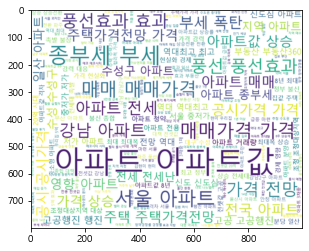

In [8]:
Kkma=Kkma() # 한글 명사 단어 추출
result=[]
for num in range(1,100): # 네이버 뉴스 "서울시 아파트 가격 영향" 검색어를 기준으로 크롤링 100페이지까지 데이터 추출
    url = f'https://search.naver.com/search.naver?sm=tab_hty.top&where=news&query=%EC%95%84%ED%8C%8C%ED%8A%B8+%EA%B0%80%EA%B2%A9+%EC%98%81%ED%96%A5&oquery=%EC%84%9C%EC%9A%B8%EC%8B%9C+%EC%95%84%ED%8C%8C%ED%8A%B8+%EA%B0%80%EA%B2%A9+%EC%98%81%ED%96%A5&tqi=h6ONzwp0JXossTO9NqhssssstX0-012366&nso=so%3Ar%2Cp%3Afrom20200101to20201130&de=2020.11.30&ds=2020.01.01&mynews=0&office_section_code=0&office_type=0&pd=3&photo=0&sort=0,a:all&start={num+10}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    news_titles = soup.select('.news_tit')
    
    for title in news_titles:
        title['title']=Kkma.nouns(title['title'])# 한글 명사 단어 추출
        title['title']=[ token for token in title['title'] if len(token) > 1 ]
        result.append(title['title'])
        
result = sum(result, [])
result =' '.join(result)

wordcloud = WordCloud(font_path="C:\Windows\Fonts\malgun.ttf",background_color='white', width=1000, height=800).generate(result)


plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()



## 구별 아파트 평균 가격 

In [42]:
# 데이터 전처리
dfMean = df.groupby('시군구명')[['거래금액']].mean()
dfMean = dfMean.sort_values(by='거래금액', ascending=False)
dfMean = dfMean.reset_index()
dfMean


,시군구명,거래금액
0,서초구,1719564776.2
1,강남구,1658443033.1
2,용산구,1495991173.1
3,송파구,1290320643.8
4,성동구,1112411833.9
5,광진구,1056556166.7
6,마포구,984717915.0
7,동작구,961377688.8
8,중구,905690045.5
9,양천구,885837664.3


# 구별 아파트 평균 가격 시각화

In [43]:
locCode = pd.read_excel('../data/법정동코드.xlsx')

locCode.dropna(subset=['읍면동명'],inplace=True)

locCode.dropna(subset=['시군구명'],inplace=True)

locCode['법정동코드']=locCode['법정동코드'].astype(str)
locCode['지역코드']=locCode['법정동코드'].apply(lambda x: x[:5])

locCode=locCode[locCode['시도명']=='서울특별시']
loc=pd.DataFrame({'시도명':locCode['시도명'],'시군구명':locCode['시군구명'],'법정동명':locCode['읍면동명'], '지역코드':locCode['지역코드']})

apt = pd.read_csv('../data/2020년 서울 아파트 실거래가.csv', encoding="cp949")

apt['건물면적'] = apt['건물면적'].astype(int) // 3.3057
apt = apt.rename({'건물면적':'평수'},axis='columns')

apt=apt[apt['건물주용도']=='아파트']
df = pd.merge(loc,apt)
df.drop_duplicates(ignore_index=True,inplace=True)

svg = open('../data/Seoul_map.svg','r',encoding="utf-8").read()
newSvg = open('Seoul_map.svg','w',encoding="utf-8")

dfMean = df.groupby('시군구명')[['거래금액']].mean()
dfMean = dfMean.sort_values(by='거래금액', ascending=False)
dfMean = dfMean.reset_index()


soup = BeautifulSoup(svg)
paths = soup.findAll('path')

path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel;fill:'
colors = ['#ff0a54','#ff477e','#ff5c8a','#ff85a1','#ff99ac','#f9bec7','#fae0e4']
    
for p in paths:
    if p['id']:
        try:
            money = dfMean[dfMean['시군구명'] == p['id']].index[0]
            count = dfMean.loc[money, '거래금액']
        except:
            continue
        
        if count >= 1000000000:
            color_class = 0
        elif count >= 900000000:
            color_class = 1
        elif count >= 800000000:
            color_class = 2
        elif count >= 700000000:
            color_class = 3
        elif count >= 600000000:
            color_class = 4
        elif count >= 500000000:
            color_class = 5
        elif count >= 400000000:
            color_class = 6
        
        color = colors[color_class]
        p['style'] = path_style + color

newSvg.write(soup.prettify())
newSvg.close()

FileNotFoundError: [Errno 2] No such file or directory: '../data/Seoul_map.svg'

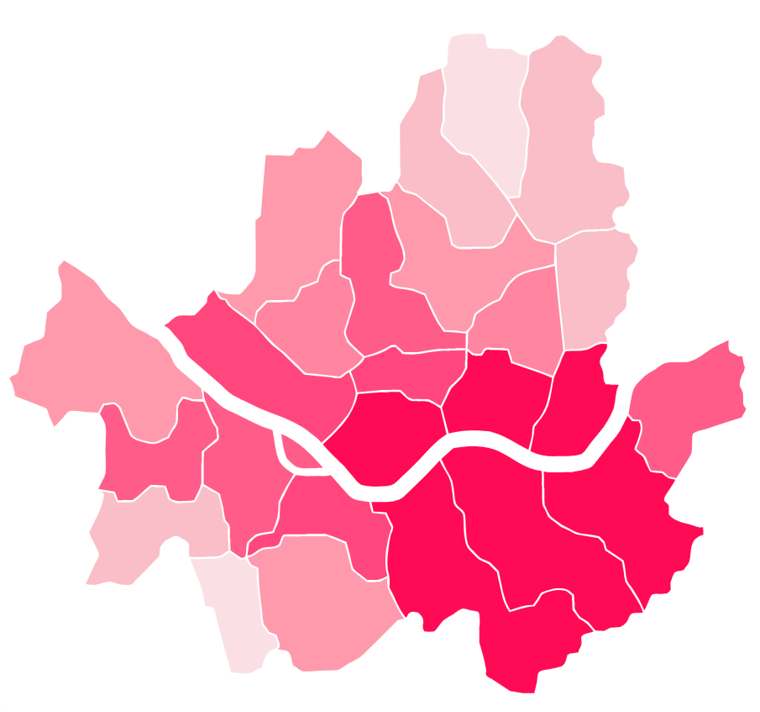

In [44]:
from IPython.display import Image
Image("../data/realestate.png")

## 구별 아파트 평당 가격

In [78]:
# 데이터 전처리
df['평당가격'] = (df['거래금액'] / df['평수']).astype(int)
apt_py = df
apt_py


,시도명,시군구명,법정동명,지역코드,평수,층정보,건물주용도,거래금액,건축년도,아파트명,평당가격
0,서울특별시,종로구,청운동,11110,25,3.0,아파트,895000000,2000.0,청운현대,35800000
1,서울특별시,종로구,청운동,11110,25,3.0,아파트,850000000,2000.0,청운현대,34000000
2,서울특별시,종로구,신교동,11110,40,5.0,아파트,1000000000,2002.0,신현(102동),25000000
3,서울특별시,종로구,필운동,11110,32,7.0,아파트,940000000,2007.0,신동아블루아광화문의 꿈,29375000
4,서울특별시,종로구,필운동,11110,33,6.0,아파트,1000000000,2007.0,신동아블루아광화문의 꿈,30303030
...,...,...,...,...,...,...,...,...,...,...,...
88343,서울특별시,강동구,강일동,11740,25,4.0,아파트,820000000,2009.0,강일리버파크6단지,32800000
88344,서울특별시,강동구,강일동,11740,25,10.0,아파트,790000000,2009.0,강일리버파크3단지,31600000
88345,서울특별시,강동구,강일동,11740,17,12.0,아파트,830000000,2009.0,강일리버파크3단지,48823529
88346,서울특별시,강동구,강일동,11740,17,13.0,아파트,760000000,2009.0,강일리버파크7단지,44705882


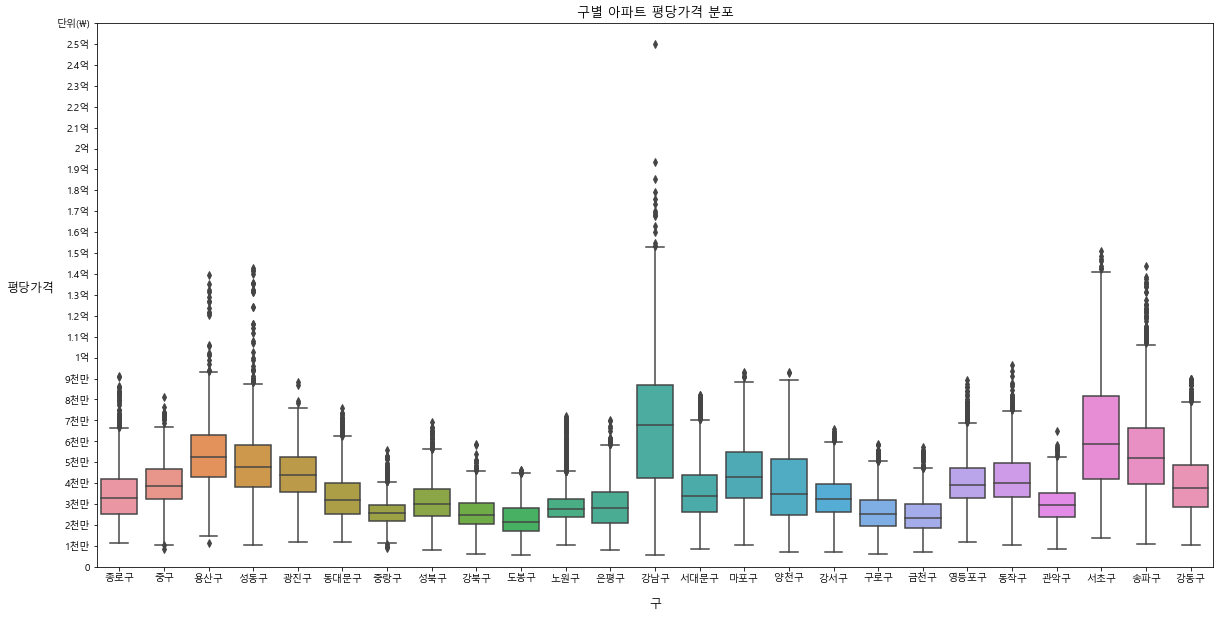

In [79]:
# boxplot으로 시각화
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim([0, 27000000])
ax.set_title('구별 아파트 평당가격 분포', size=13)
sns.boxplot(x='시군구명', y='평당가격', data=apt_py)
plt.xlabel('구', size= 12, labelpad=15)
plt.ylabel('평당가격', size= 12, rotation=0, labelpad=25)
plt.yticks(np.arange(0, 270000000, 10000000),
          ('0', '1천만','2천만','3천만','4천만','5천만','6천만','7천만','8천만','9천만',
          '1억','1.1억','1.2억','1.3억','1.4억','1.5억','1.6억','1.7억','1.8억','1.9억',
          '2억','2.1억','2.2억','2.3억','2.4억','2.5억', '단위(\)'))

plt.show()

In [85]:
df['평당거래금액']=df['거래금액']/df['평수']
pd.options.display.float_format = '{:.1f}'.format
df1=pd.concat([df['시군구명'],df['평당거래금액']],axis=1).sort_values('평당거래금액', ascending=False).head(10)
df1

,시군구명,평당거래금액
75714,강남구,250000000.0
75743,강남구,193437500.0
75727,강남구,185294117.6
75684,강남구,179000000.0
75755,강남구,176000000.0
75731,강남구,173333333.3
75763,강남구,170000000.0
75745,강남구,169166666.7
75759,강남구,168333333.3
75765,강남구,167857142.9


In [87]:
df1=pd.concat([df['시군구명'],df['평당거래금액']],axis=1).sort_values('평당거래금액', ascending=True).head(10)
df1

,시군구명,평당거래금액
21796,도봉구,5416666.7
76134,강남구,5778400.0
57378,구로구,5833333.3
20670,강북구,5882352.9
20679,강북구,6000000.0
56979,구로구,6647058.8
57604,구로구,6785714.3
52736,강서구,6842105.3
61809,금천구,6882352.9
49798,양천구,7222222.2


## 사업체 수에 따른 부동산 금액 데이터 산출

In [7]:
#농업 임업 및 어업
# 광업
# 제조업
# 전기 가스 증기 및 공기조절 공급업
# 수도 하수 및 폐기물 처리 원료 재생업
# 건설업
# 도매 및 소매업
# 운수 및 창고업
# 숙박 및 음식점업
# 정보통신업
# 금융 및 보험업
# 부동산업
# 전문 과학 및 기술 서비스업
# 사업시설 관리 사업 지원 및 임대 서비스업
# 공공행정 국방 및 사회보장 행정
# 교육 서비스업
# 보건업 및 사회복지 서비스업
# 예술 스포츠 및 여가관련 서비스업
# 협회 및 단체 수리 및 기타 개인 서비스업


seoul_=pd.read_csv('../data/seoul_.csv')
seoul_=seoul_[23:]

seoul_.columns
seoul_.drop([ '합계.1', '합계.2', '합계.3', '합계.4', '조직형태별',
       '조직형태별.1', '조직형태별.2', '조직형태별.3', '조직형태별.4', '조직형태별.5', '조직형태별.6',
       '조직형태별.7', '사업체구분별', '사업체구분별.1', '사업체구분별.2', '사업체구분별.3', '사업체구분별.4',
       '사업체구분별.5'],axis=1,inplace=True)
seoul_['합계']=seoul_['합계'].str.replace(',','').astype('int')

seoul_[seoul_['구분']=='합계'].sort_values('합계',ascending=False).head(5)

# 중구는 전체 사업체의 합계의 절반이 도매및소매업 즉 서비스업의 발달
# 즉 서비스업은 부동산 가격의 영향을 주지 않는다.

,기간,자치구,구분,합계
435,2019,강남구,합계,71027
43,2019,중구,합계,60127
455,2019,송파구,합계,48644
415,2019,서초구,합계,46940
360,2019,영등포구,합계,42370


In [6]:
seoul_[seoul_['구분']=='도매 및 소매업'].sort_values('합계',ascending=False).head(5)

,기간,자치구,구분,합계
49,2019,중구,도매 및 소매업,30681
442,2019,강남구,도매 및 소매업,16401
30,2019,종로구,도매 및 소매업,16128
462,2019,송파구,도매 및 소매업,13699
422,2019,서초구,도매 및 소매업,11890


In [8]:
seoul_[seoul_['구분']=='전문 과학 및 기술 서비스업'].sort_values('합계',ascending=False).head(5)

,기간,자치구,구분,합계
448,2019,강남구,전문 과학 및 기술 서비스업,8842
428,2019,서초구,전문 과학 및 기술 서비스업,6892
55,2019,중구,전문 과학 및 기술 서비스업,2758
468,2019,송파구,전문 과학 및 기술 서비스업,2754
277,2019,마포구,전문 과학 및 기술 서비스업,2572


## 학교 수에 따른 부동산 금액 데이터 산출

In [49]:
school = pd.read_csv('../data/서울특별시 학교 기본정보.csv', encoding='cp949')
school

,학교종류명,설립구분,표준학교코드,학교명,영문학교명,관할조직명,도로명우편번호,도로명주소,도로명상세주소,전화번호,...,주야구분명,설립일자,개교기념일,시도교육청코드,시도교육청명,소재지명,주야과정,계열명,학과명,적재일시
0,고등학교,공립,test003,(미사용)서울케이고등학교,SeoulK,서울특별시교육청,3178.0,서울특별시 종로구 송월길 48,(신문로2가/ 서울특별시교육청),22308590,...,주간,20200213,20200213,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
1,중학교,공립,test002,(미사용)서울케이중학교,SeoulK,서울특별시동부교육지원청,3178.0,서울특별시 종로구 송월길 48,(신문로2가/ 서울특별시교육청),2230-8590,...,주간,20200213,20200213,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
2,초등학교,공립,test001,(미사용)서울케이초등학교,SeoulK,서울특별시동부교육지원청,3178.0,서울특별시 종로구 송월길 48,(신문로2가/ 서울특별시교육청),2230-8590,...,주간,20200213,20200213,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
3,각종학교(중),사립,7134155,선화예술중학교,Sunhwa Arts Middle School,서울특별시성동광진교육지원청,4991.0,서울특별시 광진구 천호대로 664,/ 선화예술중고등학교 (능동),02-2204-1100,...,주간,19731201,19730705,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
4,초등학교,공립,7134150,서울숭신초등학교,Seoul Soongshin Elementary School,서울특별시성동광진교육지원청,4702.0,서울특별시 성동구 마장로 161,(하왕십리동),02-2252-5950,...,주간,19590403,19590403,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,고등학교,국립,1371661,국립국악고등학교,Gukak National High School,교육부,6311.0,서울특별시 강남구 개포로22길 65,/ (개포동/ 국립국악고등학교),02-3460-0500,...,주간,19720711,19720909,B10,서울특별시교육청,서울특별시,주간,예술계,무용과,20210422170543
3858,특수학교,국립,1342102,한국우진학교,Hanguk Woojin School,교육부,3934.0,서울특별시 마포구 월드컵북로38길 21,/ 한국우진학교 (중동),02-6388-5800,...,주간,20000301,20000306,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
3859,특수학교,국립,1342099,서울농학교,Seoul National school for the Deaf,교육부,3032.0,서울특별시 종로구 필운대로 103,(신교동),02-737-0659,...,주간,19130401,19130401,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543
3860,특수학교,국립,1342098,서울맹학교,Seoul National School for the Blind,교육부,3032.0,서울특별시 종로구 필운대로 97,(신교동),02-731-6772,...,주간,19130401,19130401,B10,서울특별시교육청,서울특별시,NaN,NaN,NaN,20210422170543


In [50]:
school = pd.DataFrame({'종류': school['학교종류명'],'구분': school['설립구분'], '학교': school['학교명'] ,'법정동명': school['도로명주소']})
school

,종류,구분,학교,법정동명
0,고등학교,공립,(미사용)서울케이고등학교,서울특별시 종로구 송월길 48
1,중학교,공립,(미사용)서울케이중학교,서울특별시 종로구 송월길 48
2,초등학교,공립,(미사용)서울케이초등학교,서울특별시 종로구 송월길 48
3,각종학교(중),사립,선화예술중학교,서울특별시 광진구 천호대로 664
4,초등학교,공립,서울숭신초등학교,서울특별시 성동구 마장로 161
...,...,...,...,...
3857,고등학교,국립,국립국악고등학교,서울특별시 강남구 개포로22길 65
3858,특수학교,국립,한국우진학교,서울특별시 마포구 월드컵북로38길 21
3859,특수학교,국립,서울농학교,서울특별시 종로구 필운대로 103
3860,특수학교,국립,서울맹학교,서울특별시 종로구 필운대로 97


In [51]:
date_list = school['법정동명'].str.split(' ')
date_list
school['시군구명'] = date_list.str.get(1)
school.drop(columns=['법정동명'],inplace=True)
school.drop([0,1,2],inplace=True)
school.reset_index(drop=True,inplace=True)
school = school.drop_duplicates(['학교'],keep = 'last',ignore_index=True)
school

,종류,구분,학교,시군구명
0,각종학교(중),사립,선화예술중학교,광진구
1,초등학교,공립,서울숭신초등학교,성동구
2,중학교,공립,행당중학교,성동구
3,중학교,사립,한양대학교사범대학부속중학교,성동구
4,중학교,공립,자양중학교,광진구
...,...,...,...,...
1417,고등학교,국립,국립국악고등학교,강남구
1418,특수학교,국립,한국우진학교,마포구
1419,특수학교,국립,서울농학교,종로구
1420,특수학교,국립,서울맹학교,종로구


In [74]:
schools = school[(school['종류'] !='초등학교') & 
                 (school['종류'] !='중학교') &
                 (school['종류'] !='고등학교') &
                 (school['종류'] !='특수학교')].index
school.drop(schools, inplace=True)
school.reset_index(drop=True, inplace=True)
school

C:\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,종류,구분,학교,시군구명
0,초등학교,공립,서울숭신초등학교,성동구
1,중학교,공립,행당중학교,성동구
2,중학교,사립,한양대학교사범대학부속중학교,성동구
3,중학교,공립,자양중학교,광진구
4,중학교,공립,용곡중학교,광진구
...,...,...,...,...
1349,고등학교,국립,국립전통예술고등학교,금천구
1350,고등학교,국립,국립국악고등학교,강남구
1351,특수학교,국립,한국우진학교,마포구
1352,특수학교,국립,서울농학교,종로구


In [63]:
school.pivot_table('학교',index=['시군구명','구분'],aggfunc= ['count'],margins=True)

count
           학교
시군구명 구분      
강남구  공립    59
     국립     2
     사립    23
강동구  공립    46
     사립    18
강북구  공립    25
     사립    13
강서구  공립    57
     사립    30
관악구  공립    42
     사립    17
광진구  공립    32
     사립    15
구로구  공립    48
     사립    10
금천구  공립    27
     국립     2
     사립     6
노원구  공립    67
     사립    34
도봉구  공립    39
     사립     9
동대문구 공립    30
     사립    20
동작구  공립    39
     사립    13
마포구  공립    34
     국립     1
     사립    17
서대문구 공립    24
     사립    19
서초구  공립    43
     국립     1
     사립    13
성동구  공립    38
     사립     3
성북구  공립    38
     국립     2
     사립    22
송파구  공립    73
     사립    20
양천구  공립    50
     사립    14
영등포구 공립    43
     사립     4
용산구  공립    22
     사립    17
은평구  공립    42
     사립    28
종로구  공립    20
     국립     4
     사립    23
중구   공립    16
     사립    20
중랑구  공립    38
     사립     9
All      1421

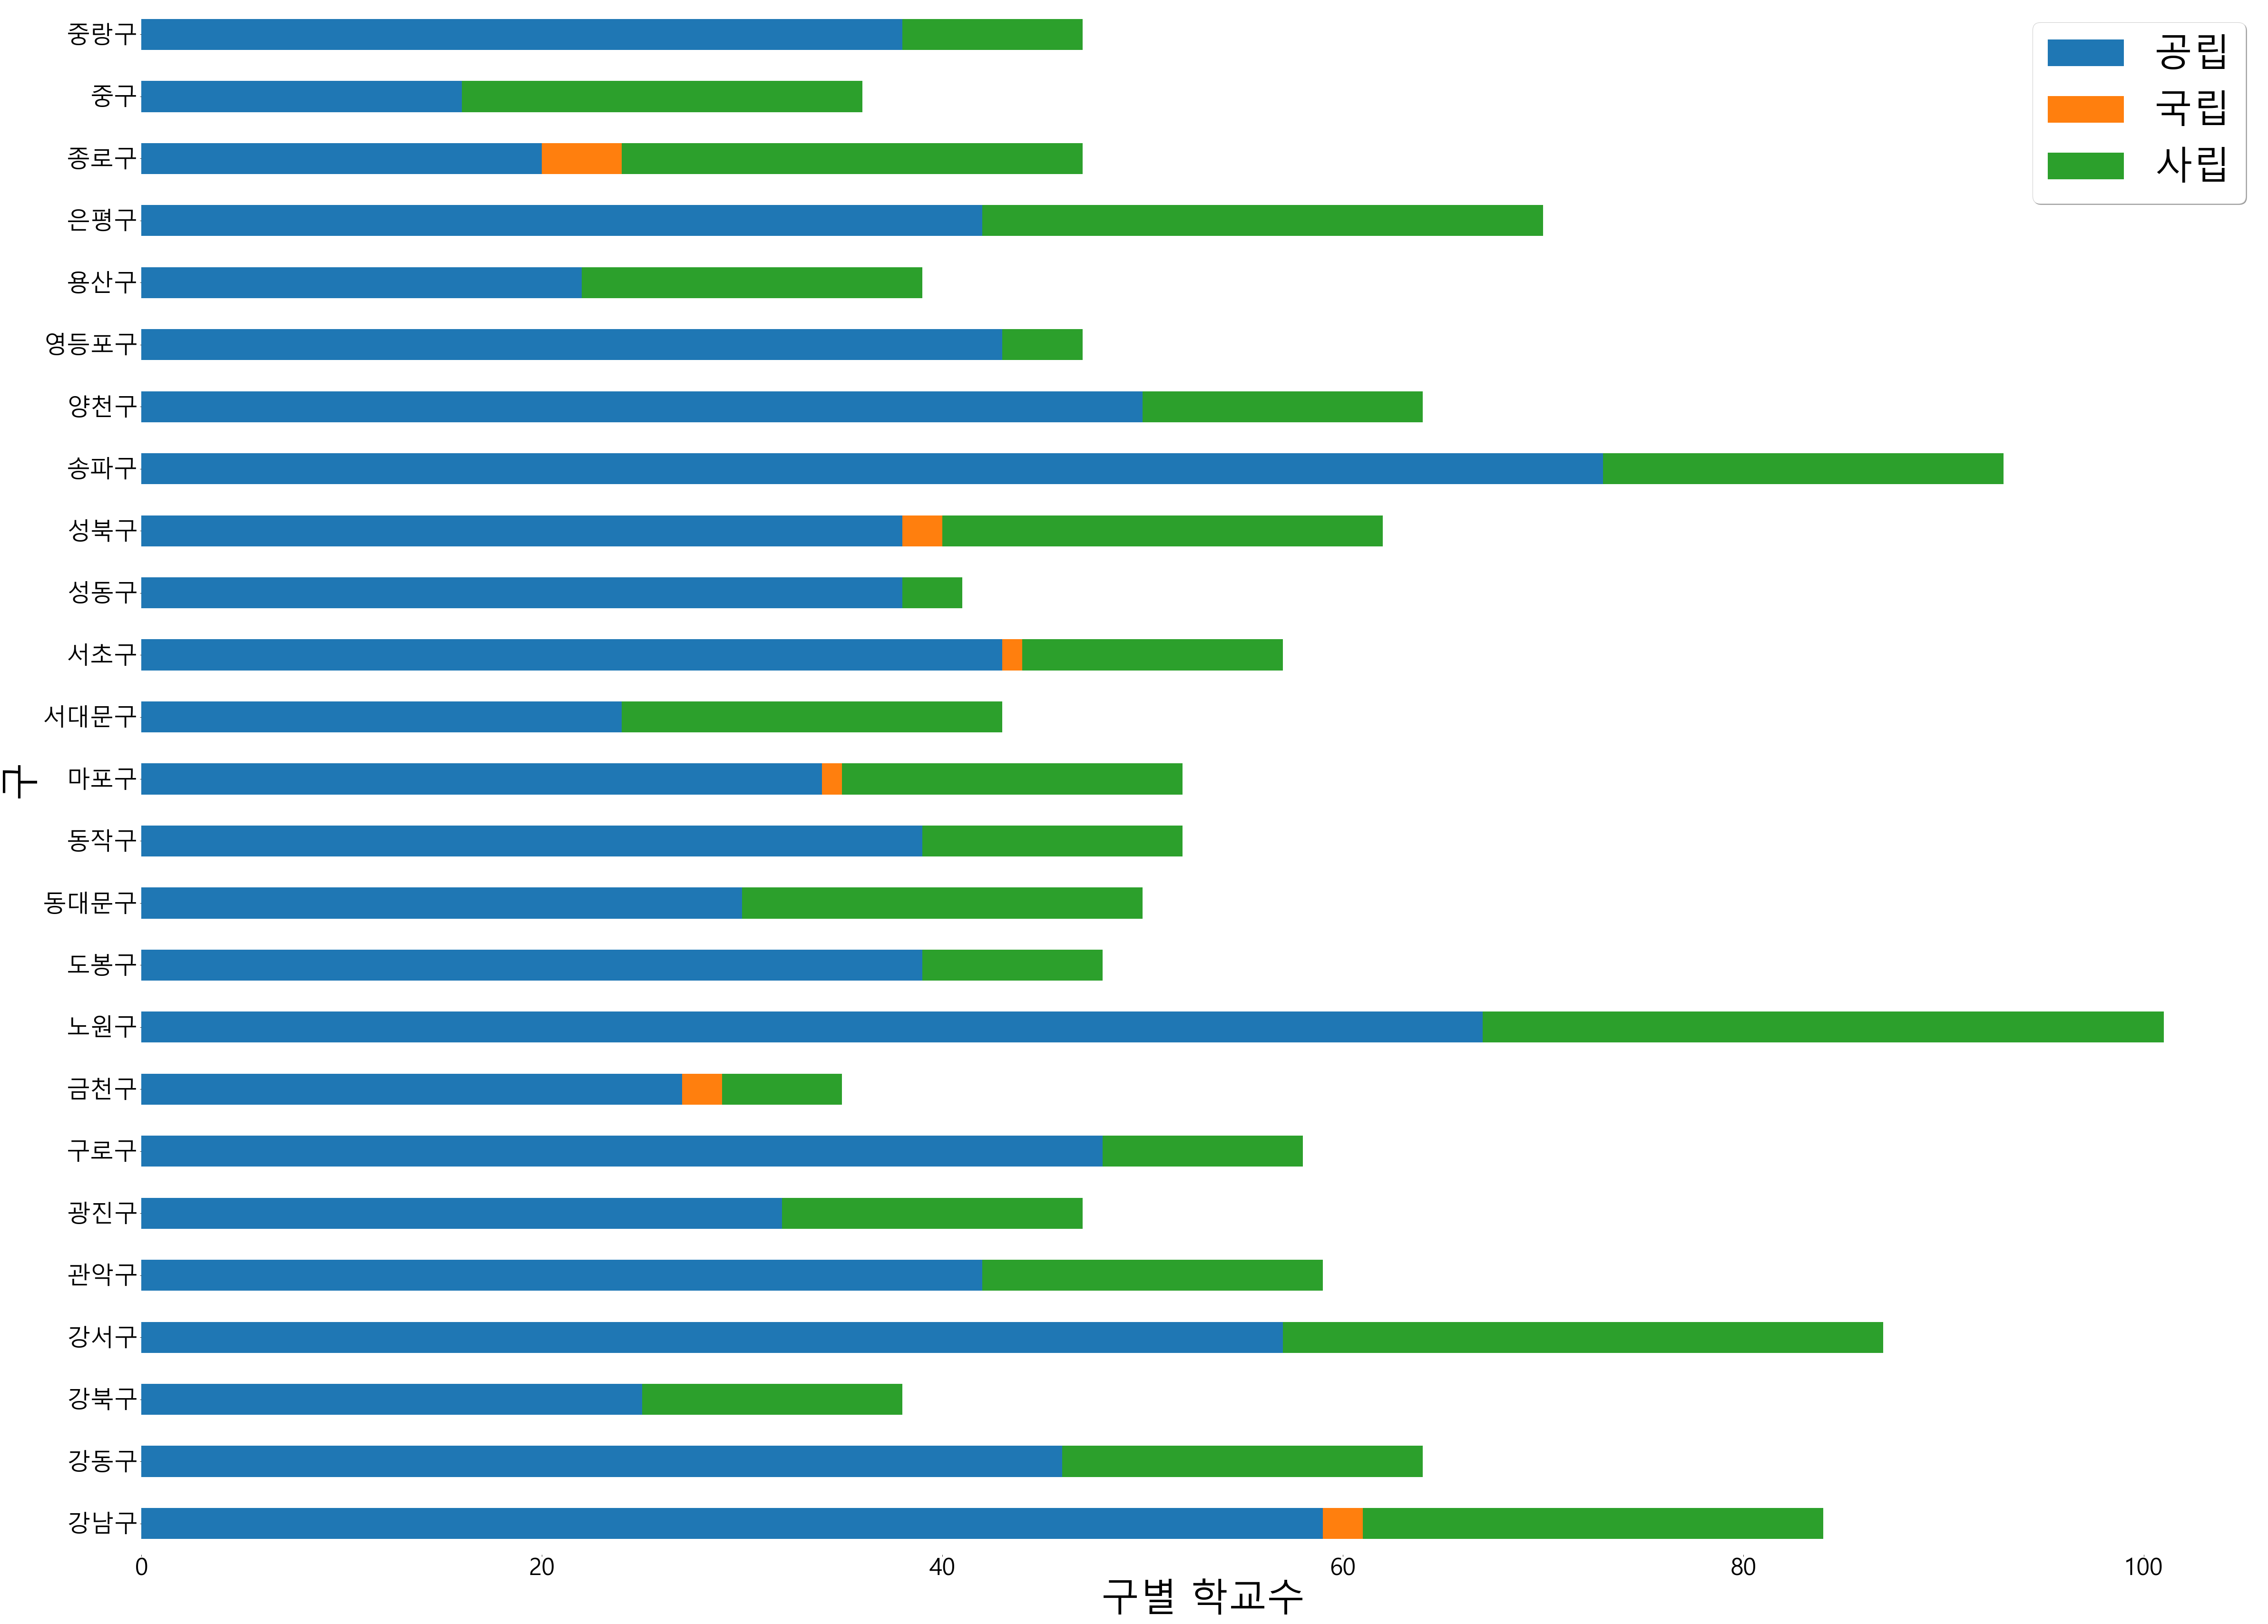

In [64]:
school.groupby(['시군구명','구분'])['종류'].count().unstack().plot(kind='barh', stacked=True)
plt.xlabel('구별 학교수',size=80)
plt.ylabel('구',size=80)
plt.xticks(size=50)
plt.yticks(size=50)
plt.rcParams['figure.figsize'] = [80,60]
plt.legend(loc='best', fontsize=80, frameon=True, shadow=True)
plt.box(False)
plt.show()

In [ ]:
 # 학교의 수 보다 학교의 인지도(?) 명문학교 즉, 교육의 중심지에 부동산 가격이 영향 받는 것 같다.

## 

In [91]:
subway = pd.read_csv('../data/서울교통공사_자치구별 지하철역2_20160430.csv', encoding="cp949")
subway

,자치구,역개수
0,종로구,13
1,중구,18
2,용산구,8
3,성동구,15
4,광진구,9
5,동대문구,11
6,중랑구,12
7,성북구,12
8,강북구,11
9,도봉구,6


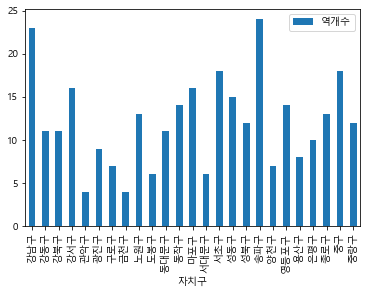

<Figure size 720x576 with 0 Axes>

In [7]:
subway = pd.read_csv('../data/서울교통공사_자치구별 지하철역2_20160430.csv', encoding="cp949")
subway
subway.pivot_table('역개수',index=['자치구'],aggfunc='mean').plot(kind='bar')
plt.figure(figsize=(10, 8))
plt.show()


# 결론 
모든 요인들이 영향을 주지만 하나의 요인에 치중되지 않는 것 같으며 외부적인 다른 요인이 존재한다.

#### 용산구) 서울역 존재